# Auto Poster Generation
## 当前任务
### 打分器（实际上可看作二分类问题）
#### 1. 输入
- 正样本：已有的海报图像，label为1
- 负样本：在现有海报图像的基础上随机搭配，label为0

#### 2. 网络结构
- 可以用现有的卷积基模型，可能需要fine-tune
- 也可以自己构造一个简单的模型（尝试）
- 对于卷积基提取的特征，后面接上Flatten和Dense层，最后做一个二分类

#### 3. 输出
- 输出的概率值既可以看作是打分器的分数

In [1]:
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
standard_width = 200
standard_height = 280

### 读取数据集并进行预处理

In [3]:
import glob
import os
import numpy as np
from PIL import Image
import import_ipynb
from imgAugmentation import ImageProcess


def getAllFiles(rootDir):
    files = []
    fileList = os.listdir(rootDir) #列出文件夹下所有的目录与文件
    
    for i in fileList:
        
        path = os.path.join(rootDir, i)
        if os.path.isdir(path):
            files.extend(getAllFiles(path))
        elif os.path.isfile(path):
            files.append(path)
    return files


importing Jupyter notebook from imgAugmentation.ipynb


In [6]:
poster_positive = glob.glob('./data/poster_positive/*.png')
poster_negative = glob.glob('./data/poster_negative/*.png')
poster_positive += glob.glob('./data/poster_positive_aug/*.png')
poster_negative += glob.glob('./data/poster_negative_overlap_aug/*.png')
poster_negative += glob.glob('./data/poster_negative_overlap_ori/*.png')

In [7]:
np.random.shuffle(poster_positive)
np.random.shuffle(poster_negative)
poster_positive_num = len(poster_positive)
poster_negative_num = len(poster_negative)

print("poster positive num: " + str(poster_positive_num))
print("poster negative num: " + str(poster_negative_num))

poster positive num: 8487
poster negative num: 9613


## 使用RGB图像训练-多进程

In [8]:
import random
from multiprocessing import Pool
from multiprocessing import sharedctypes
import ctypes

debug = False

num_train_positive = 8000
num_train_negative = 8000

num_validation_positive = 200
num_validation_negative = 200

num_test_positive = 200
num_test_negative = 200

# tuple(number, height, width, dimension)

X_train = np.ctypeslib.as_ctypes(np.empty((num_train_positive + num_train_negative, standard_height, standard_width, 3)))
Y_train = np.ctypeslib.as_ctypes(np.empty((num_train_positive + num_train_negative, 1)))

X_validation = np.ctypeslib.as_ctypes(np.empty((num_validation_positive + num_validation_negative, standard_height, standard_width, 3)))
Y_validation = np.ctypeslib.as_ctypes(np.empty((num_validation_positive + num_validation_negative, 1)))

X_test = np.ctypeslib.as_ctypes(np.empty((num_test_positive + num_test_negative, standard_height, standard_width, 3)))
Y_test = np.ctypeslib.as_ctypes(np.empty((num_test_positive + num_test_negative, 1)))

# create Shared_memory of each set
X_train_sh = sharedctypes.RawArray(X_train._type_, X_train)
Y_train_sh = sharedctypes.RawArray(Y_train._type_, Y_train)

X_validation_sh = sharedctypes.RawArray(X_validation._type_, X_validation)
Y_validation_sh = sharedctypes.RawArray(Y_validation._type_, Y_validation)

X_test_sh = sharedctypes.RawArray(X_test._type_, X_test)
Y_test_sh = sharedctypes.RawArray(Y_test._type_, Y_test)


print('begin to process')

def trainSetPositive(i):
    try:
        im = Image.open(poster_positive[i]).convert('RGB')
        X_train_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
        Y_train_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
        if debug:
            print('finish train positive', i)
    except Exception as e:
        print(e)

def trainSetNegative(i):
    try:
        im = Image.open(poster_negative[i]).convert('RGB')
        X_train_sh[num_train_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
        Y_train_sh[num_train_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
        if debug:
            print('finish train negative', i)
    except Exception as e:
        print(e)
    
def validationSetPositive(i):
    im = Image.open(poster_positive[num_train_positive + i]).convert('RGB')
    X_validation_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_validation_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
    if debug:
        print('finish validation positive', i)
    
def validationSetNegative(i):
    im = Image.open(poster_negative[num_train_negative + i]).convert('RGB')
    X_validation_sh[num_validation_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_validation_sh[num_validation_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
    if debug:
        print('finish validation negative', i)
    
def testSetPositive(i):
    im = Image.open(poster_positive[num_train_positive + num_validation_positive + i]).convert('RGB')
    X_test_sh[i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_test_sh[i] = np.ctypeslib.as_ctypes(np.array([1.]))
    if debug:
        print('finish test positive', i)
    
def testSetNegative(i):
    im = Image.open(poster_negative[num_train_negative + num_validation_negative + i]).convert('RGB')
    X_test_sh[num_test_positive + i] = np.ctypeslib.as_ctypes(np.array(im) / 255.)
    Y_test_sh[num_test_positive + i] = np.ctypeslib.as_ctypes(np.array([0.]))
    if debug:
        print('finish test negative', i)
    
# initialize the process pool
## ATTENTION: pool must be initialized after function
pool = Pool()


# make train set

for i in range(num_train_positive):
    pool.apply_async(trainSetPositive, args=(i,))
for i in range(num_train_negative):
    pool.apply_async(trainSetNegative, args=(i,))

# convert Ctype to numpy
X_train = np.ctypeslib.as_array(X_train_sh)
Y_train = np.ctypeslib.as_array(Y_train_sh)
    
# # shuffle the whole train set
# zipped = list(zip(X_train, Y_train))
# np.random.shuffle(zipped)
# X_train[:], Y_train[:] = zip(*zipped)

# another shuffle method
index = [i for i in range(len(X_train))]
random.shuffle(index)
X_train = X_train[index]
Y_train = Y_train[index]


print(np.array(X_train).shape, np.array(Y_train).shape)
assert len(X_train) == len(Y_train)

print("train set initialization finished!")

# make validation set

for i in range(num_validation_positive):
    pool.apply_async(validationSetPositive, args=(i,))
    
for i in range(num_validation_negative):
    pool.apply_async(validationSetNegative, args=(i,))

# convert Ctype to numpy
X_validation = np.ctypeslib.as_array(X_validation_sh)
Y_validation = np.ctypeslib.as_array(Y_validation_sh)

print(np.array(X_validation).shape, np.array(Y_validation).shape)
assert len(X_validation) == len(Y_validation)

print("validation set initialization finished!")

# make test set
for i in range(num_test_positive):
    pool.apply_async(testSetPositive, args=(i,))

for i in range(num_test_negative):
    pool.apply_async(testSetNegative, args=(i,))

# convert Ctype to numpy
X_test = np.ctypeslib.as_array(X_test_sh)
Y_test = np.ctypeslib.as_array(Y_test_sh)

print(np.array(X_test).shape, np.array(Y_test).shape)
assert len(X_test) == len(Y_test)

print("test set initialization finished!")

pool.close()
pool.join()

print("finish")

begin to process
unrecognized data stream contents when reading image file
unrecognized data stream contents when reading image file
broken data stream when reading image file
unrecognized data stream contents when reading image file
unrecognized data stream contents when reading image file
(16000, 280, 200, 3) (16000, 1)
train set initialization finished!
(400, 280, 200, 3) (400, 1)
validation set initialization finished!
(400, 280, 200, 3) (400, 1)
test set initialization finished!
finish


### test for data production

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(Y_train[10:100])
print(X_test.shape)
print(Y_test.shape)
print(Y_test[10:100])
print(X_validation.shape)
print(Y_validation.shape)
print(Y_validation[10:100])

In [14]:
# 将VGG16卷积基实例化
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(standard_height, standard_width, 3))

In [15]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 280, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 280, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 280, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 140, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 140, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 140, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 70, 50, 128)       0         
__________

In [16]:
# 在卷积基上添加一个密集链接分类器
from keras import models
from keras import layers
from keras import regularizers

# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu',
#                        kernel_initializer='glorot_normal', bias_initializer='zeros',
#                        kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(layers.Dense(1,activation='sigmoid', kernel_initializer='glorot_normal', bias_initializer='zeros'))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6291712   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,006,657
Trainable params: 21,006,657
Non-trainable params: 0
_________________________________________________________________


In [18]:
# freeze the pre-train model VGG
conv_base.trainable = False
print(len(model.trainable_weights))

4


In [19]:
# compile the model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# load weights
model_path = './model_save/'
model_name = 'vgg16_final.h5'
if not os.path.exists(model_path):
    os.mkdirs(model_path)
    print("create new dirctory:", model_path)
if os.path.isfile(model_path + model_name):
    model.load_weights(model_path + model_name)
    print("load weights")

In [21]:
# train the model
history = model.fit(X_train,
                    Y_train,
                    epochs=5,
                    batch_size=70,
                    validation_data=(X_validation, Y_validation))


Train on 16000 samples, validate on 400 samples
Epoch 1/5
16000/16000 [==============================] - 308s 19ms/step - loss: 0.2720 - acc: 0.8975 - val_loss: 0.0891 - val_acc: 0.9725
Epoch 2/5
16000/16000 [==============================] - 295s 18ms/step - loss: 0.1837 - acc: 0.9247 - val_loss: 0.0865 - val_acc: 0.9775
Epoch 3/5
16000/16000 [==============================] - 295s 18ms/step - loss: 0.1726 - acc: 0.9256 - val_loss: 0.0951 - val_acc: 0.9725
Epoch 4/5
16000/16000 [==============================] - 295s 18ms/step - loss: 0.1583 - acc: 0.9331 - val_loss: 0.0774 - val_acc: 0.9775
Epoch 5/5
16000/16000 [==============================] - 295s 18ms/step - loss: 0.1503 - acc: 0.9372 - val_loss: 0.1514 - val_acc: 0.9400


In [22]:
results = model.evaluate(X_test, Y_test)
print(results)

400/400 [==============================] - 11s 26ms/step
[0.05984994520433247, 0.98]


In [23]:
# save weights
model.save_weights(model_path + model_name)

# save the whole architecture
arch_name = "model_arch.h5"
model.save(model_path + arch_name)

In [ ]:
model.predict(X_test)

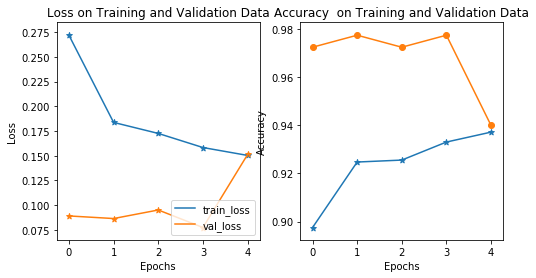

In [26]:
import matplotlib.pyplot as plt
def trainVisualization(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))

    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.scatter(history.epoch, history.history['loss'], marker='*')
    ax1.scatter(history.epoch, history.history['val_loss'], marker='*')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend(loc='upper right')

    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.scatter(history.epoch, history.history['acc'], marker='*')
    ax2.scatter(history.epoch, history.history['val_acc'])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax1.legend(loc='lower right')

trainVisualization(history)